
Loading TRAIN isocontours...
Loading TEST isocontours...

Aligning feature sets (intersection of numeric columns)...
Common candidate features: 34

Train samples: 49610 | Test samples: 44409
Target: DW_FDS

Computing MI + mRMR on TRAIN only...
mRMR step 01: density_ratio_sigma (score=2.2181, relevance=2.2181)
mRMR step 02: abs_flame_prop_vel_normal (score=0.1987, relevance=0.9855)
mRMR step 03: curvature (score=0.2459, relevance=1.0130)
mRMR step 04: total_heat_conduction (score=0.2986, relevance=1.6915)
mRMR step 05: flow_velocity_tangential (score=0.2692, relevance=1.5689)
mRMR step 06: stretch_rate (score=0.0269, relevance=1.0197)
mRMR step 07: H2O (score=0.1154, relevance=1.9435)
mRMR step 08: strain_rate (score=-0.0146, relevance=0.6339)
mRMR step 09: u (score=0.0614, relevance=1.3481)
mRMR step 10: omega_H2 (score=-0.0177, relevance=1.1079)

Selected features (mRMR order):
  01. density_ratio_sigma
  02. abs_flame_prop_vel_normal
  03. curvature
  04. total_heat_conduction
  05.

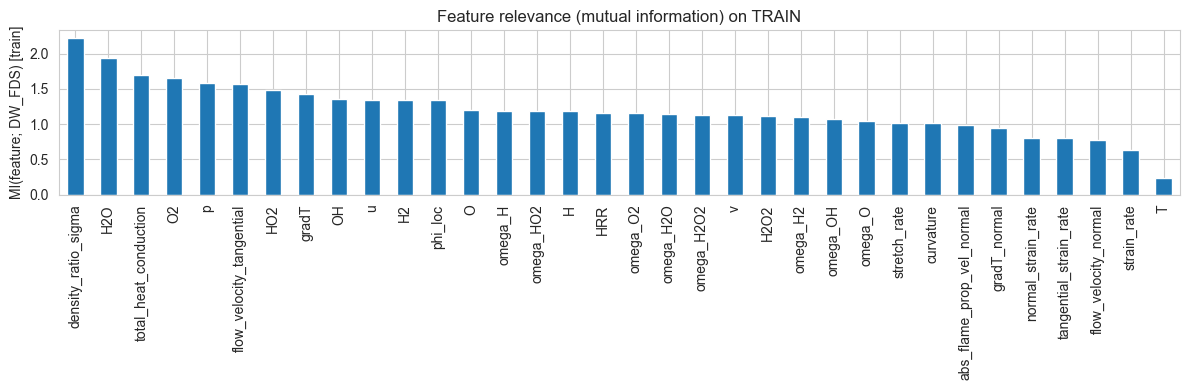


=== RF (curvature only) | Train: t=212, L=100 -> Test: t=175, L=100 ===
R^2  : -0.0871
RMSE : 6.242062e-01
MAE  : 4.918590e-01


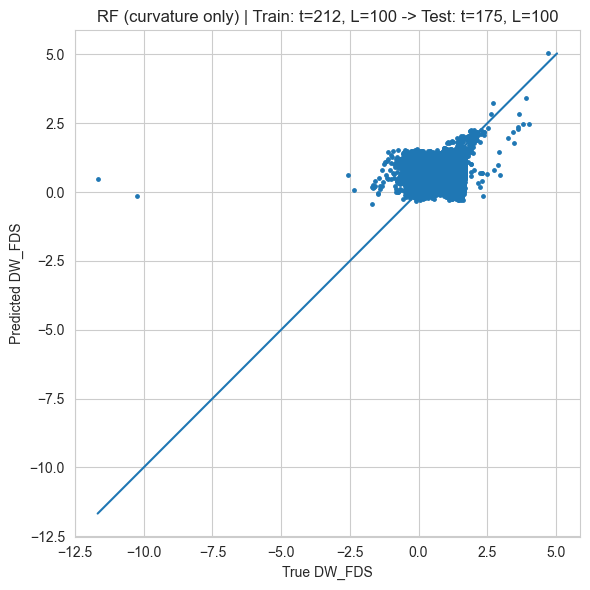


=== RF (mRMR top-10) | Train: t=212, L=100 -> Test: t=175, L=100 ===
R^2  : 0.9386
RMSE : 1.482962e-01
MAE  : 4.612114e-02


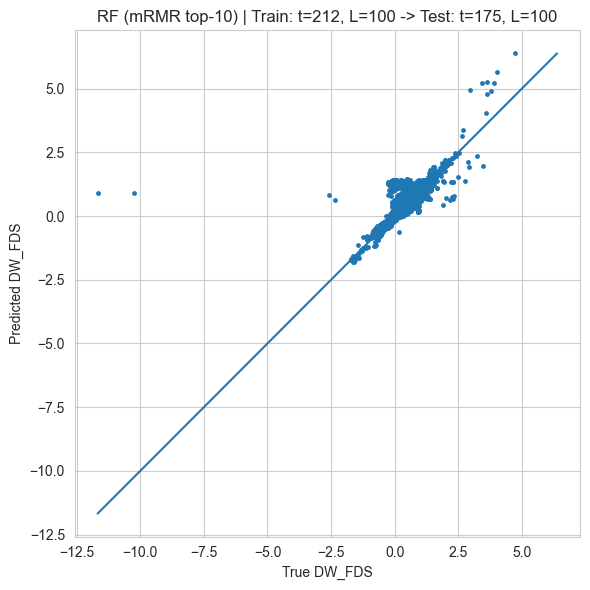

In [2]:
# ============================================================
# Cross-time / cross-domain Sd prediction from isocontour CSVs
# ============================================================

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# ============================================================
# USER SETTINGS
# ============================================================

BASE_DIR = Path("../isocontours")  # points to: ../isocontours/phi0.40/...

ISOLEVELS = [3.5, 3.8, 4.1, 4.2, 4.3, 4.4, 4.5, 4.7]

TARGET_VAR = "DW_FDS"   # your Sd-like target column

# Exclude non-features (edit as needed)
COLS_TO_EXCLUDE = [
    "x", "y", "z",
    TARGET_VAR,
    # optionally exclude nuisance / constants / IDs
    "N2", "omega_N2",
]

# Whether to include c_iso (the isolevel label) as a feature
INCLUDE_C_ISO_AS_FEATURE = False

# Feature selection count (mRMR)
K_SELECT = 10

# Model hyperparameters
RF_PARAMS = dict(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=0,
    n_jobs=-1,
)

# ------------------------------------------------------------
# Define the TRAIN and TEST cases
# (Different time_step and/or lat_size -> different domain size)
# ------------------------------------------------------------

@dataclass(frozen=True)
class CaseConfig:
    phi: float = 0.40
    lat_size: str = "100"          # domain size tag used in folder name
    time_step: int = 212
    post: bool = True
    multiple_runs: bool = False
    n_RUN: int = 1
    Soret_term: bool = False
    Soret_positive: bool = False
    h_tag: str = "h400"            # if you ever change h400 -> edit here


TRAIN_CASE = CaseConfig(
    phi=0.40,
    lat_size="100",
    time_step=212,
    post=True,
    multiple_runs=False,
    n_RUN=2,
    Soret_term=False,
    Soret_positive=False,
)

TEST_CASE = CaseConfig(
    phi=0.40,
    lat_size="100",   # <-- different domain size (example)
    time_step=175,    # <-- different time step (example)
    post=True,
    multiple_runs=False,
    n_RUN=2,
    Soret_term=False,
    Soret_positive=False,
)


# ============================================================
# IO helpers
# ============================================================

def case_folder(cfg: CaseConfig) -> Path:
    """
    Reconstruct your folder logic:
      ../isocontours/phi{phi}/h400x{lat_size}_ref[_Soret_positive][/RUN0{n_RUN}]
    """
    phi_dir = BASE_DIR / f"phi{cfg.phi:.2f}"

    if cfg.Soret_term and cfg.Soret_positive:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref_Soret_positive"
    elif cfg.Soret_term:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref"
    else:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref"

    if cfg.multiple_runs:
        folder = folder / f"RUN0{cfg.n_RUN}"

    return folder


def isofile_name(cfg: CaseConfig, c_val: float) -> str:
    if cfg.post:
        return f"extracted_flame_front_post_{cfg.time_step}_iso_{c_val}.csv"
    return f"extracted_flame_front_{cfg.time_step}_iso_{c_val}.csv"


def load_isocontours(cfg: CaseConfig, isolevels: List[float]) -> Dict[float, pd.DataFrame]:
    folder = case_folder(cfg)
    dataset: Dict[float, pd.DataFrame] = {}

    for c_val in isolevels:
        fpath = folder / isofile_name(cfg, c_val)
        if not fpath.exists():
            raise FileNotFoundError(
                f"Missing file:\n  {fpath}\n"
                f"Check BASE_DIR / phi / folder naming / time_step / lat_size / post flag."
            )
        df = pd.read_csv(fpath)
        dataset[c_val] = df

    return dataset


def concat_fronts(dataset: Dict[float, pd.DataFrame]) -> pd.DataFrame:
    all_fronts = []
    for c_val, front in dataset.items():
        f = front.copy()
        f["c_iso"] = float(c_val)
        all_fronts.append(f)
    return pd.concat(all_fronts, ignore_index=True)


# ============================================================
# Feature preparation
# ============================================================

def build_feature_list(df: pd.DataFrame, target_var: str) -> List[str]:
    cols_excl = set(COLS_TO_EXCLUDE)
    if not INCLUDE_C_ISO_AS_FEATURE:
        cols_excl.add("c_iso")

    feature_cols = [c for c in df.columns if c not in cols_excl]

    # Remove obviously-non-numeric columns (safety)
    numeric_features = []
    for c in feature_cols:
        if pd.api.types.is_numeric_dtype(df[c]):
            numeric_features.append(c)

    if target_var not in df.columns:
        raise ValueError(f"Target column '{target_var}' not found in dataframe columns.")

    return numeric_features


def align_train_test_features(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    target_var: str,
) -> List[str]:
    """
    Use only the intersection of numeric feature columns between train and test.
    This is critical for cross-case generalization.
    """
    train_feats = set(build_feature_list(df_train, target_var))
    test_feats  = set(build_feature_list(df_test,  target_var))

    common = sorted(list(train_feats.intersection(test_feats)))
    if len(common) == 0:
        raise ValueError("No common feature columns between train and test after exclusions.")

    return common


def clean_xy(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_var: str
) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    df_clean = df.dropna(subset=feature_cols + [target_var]).copy()
    X = df_clean[feature_cols].to_numpy()
    y = df_clean[target_var].to_numpy()
    return X, y, df_clean


# ============================================================
# MI + greedy mRMR (train only)
# ============================================================

def mrmr_greedy(
    X: np.ndarray,
    y: np.ndarray,
    feature_cols: List[str],
    k_select: int,
    random_state: int = 0
) -> Tuple[List[str], pd.Series]:
    """
    Greedy mRMR:
      score(j) = I(X_j; y) - mean_{s in selected} I(X_j; X_s)
    MI estimated via mutual_info_regression.
    """
    n_samples, n_features = X.shape
    k_select = int(min(k_select, n_features))

    # Relevance: I(feature; target)
    mi_ft = mutual_info_regression(X, y, random_state=random_state)
    mi_ft_series = pd.Series(mi_ft, index=feature_cols).sort_values(ascending=False)

    # Redundancy: symmetric MI matrix I(feature_i; feature_j)
    mi_ff = np.zeros((n_features, n_features), dtype=float)
    for i in range(n_features):
        Xi = X[:, [i]]  # 2D
        for j in range(i + 1, n_features):
            Xj = X[:, j]  # 1D
            mi_ij = mutual_info_regression(Xi, Xj, random_state=random_state)[0]
            mi_ff[i, j] = mi_ij
            mi_ff[j, i] = mi_ij

    selected_idx: List[int] = []
    selected_feats: List[str] = []

    for step in range(k_select):
        best_score = -np.inf
        best_j: Optional[int] = None

        for j in range(n_features):
            if j in selected_idx:
                continue
            relevance = mi_ft[j]
            redundancy = 0.0 if len(selected_idx) == 0 else float(np.mean([mi_ff[j, s] for s in selected_idx]))
            score = relevance - redundancy

            if score > best_score:
                best_score = score
                best_j = j

        assert best_j is not None
        selected_idx.append(best_j)
        selected_feats.append(feature_cols[best_j])
        print(f"mRMR step {step+1:02d}: {feature_cols[best_j]} "
              f"(score={best_score:.4f}, relevance={mi_ft[best_j]:.4f})")

    return selected_feats, mi_ft_series


# ============================================================
# Training / Evaluation
# ============================================================

def fit_and_evaluate(
    X_train: np.ndarray, y_train: np.ndarray,
    X_test: np.ndarray,  y_test: np.ndarray,
    model,
    label: str
) -> Dict[str, float]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae  = float(mean_absolute_error(y_test, y_pred))

    print(f"\n=== {label} ===")
    print(f"R^2  : {r2:.4f}")
    print(f"RMSE : {rmse:.6e}")
    print(f"MAE  : {mae:.6e}")

    # Parity plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, s=6)
    lo = min(np.min(y_test), np.min(y_pred))
    hi = max(np.max(y_test), np.max(y_pred))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel(f"True {TARGET_VAR}")
    plt.ylabel(f"Predicted {TARGET_VAR}")
    plt.title(label)
    plt.tight_layout()
    plt.show()

    return {"r2": float(r2), "rmse": rmse, "mae": mae}


# ============================================================
# Main
# ============================================================

def main():
    print("\nLoading TRAIN isocontours...")
    train_dataset = load_isocontours(TRAIN_CASE, ISOLEVELS)
    df_train_all = concat_fronts(train_dataset)

    print("Loading TEST isocontours...")
    test_dataset = load_isocontours(TEST_CASE, ISOLEVELS)
    df_test_all = concat_fronts(test_dataset)

    print("\nAligning feature sets (intersection of numeric columns)...")
    common_features = align_train_test_features(df_train_all, df_test_all, TARGET_VAR)
    print(f"Common candidate features: {len(common_features)}")

    # Clean NaNs separately (train/test)
    X_train, y_train, df_train_clean = clean_xy(df_train_all, common_features, TARGET_VAR)
    X_test,  y_test,  df_test_clean  = clean_xy(df_test_all,  common_features, TARGET_VAR)

    print(f"\nTrain samples: {len(y_train)} | Test samples: {len(y_test)}")
    print(f"Target: {TARGET_VAR}")

    # -------------------------
    # Feature selection on TRAIN
    # -------------------------
    print("\nComputing MI + mRMR on TRAIN only...")
    selected_features, mi_rank = mrmr_greedy(
        X_train, y_train,
        common_features,
        k_select=K_SELECT,
        random_state=0
    )

    print("\nSelected features (mRMR order):")
    for k, f in enumerate(selected_features, 1):
        print(f"  {k:02d}. {f}")

    # Plot MI ranking (train)
    plt.figure(figsize=(12, 4))
    mi_rank.plot(kind="bar")
    plt.ylabel(f"MI(feature; {TARGET_VAR}) [train]")
    plt.title("Feature relevance (mutual information) on TRAIN")
    plt.tight_layout()
    plt.show()

    # -------------------------
    # Build train/test matrices for chosen features
    # -------------------------
    def col_idx(name: str) -> int:
        return common_features.index(name)

    # Baseline: curvature only (if available)
    if "curvature" in common_features:
        Xtr_curv = X_train[:, [col_idx("curvature")]]
        Xte_curv = X_test[:,  [col_idx("curvature")]]
    else:
        Xtr_curv, Xte_curv = None, None
        print("\nNote: 'curvature' not in common features; skipping curvature-only baseline.")

    # mRMR features
    sel_indices = [col_idx(f) for f in selected_features]
    Xtr_sel = X_train[:, sel_indices]
    Xte_sel = X_test[:,  sel_indices]

    # -------------------------
    # Train models and evaluate on TEST case
    # -------------------------
    if Xtr_curv is not None:
        rf_curv = RandomForestRegressor(**RF_PARAMS)
        fit_and_evaluate(
            Xtr_curv, y_train,
            Xte_curv, y_test,
            rf_curv,
            label=f"RF (curvature only) | Train: t={TRAIN_CASE.time_step}, L={TRAIN_CASE.lat_size} -> "
                  f"Test: t={TEST_CASE.time_step}, L={TEST_CASE.lat_size}"
        )

    rf_sel = RandomForestRegressor(**RF_PARAMS)
    fit_and_evaluate(
        Xtr_sel, y_train,
        Xte_sel, y_test,
        rf_sel,
        label=f"RF (mRMR top-{len(selected_features)}) | Train: t={TRAIN_CASE.time_step}, L={TRAIN_CASE.lat_size} -> "
              f"Test: t={TEST_CASE.time_step}, L={TEST_CASE.lat_size}"
    )


if __name__ == "__main__":
    main()
